# **Face pos Estimation using mediapipe**

In [1]:
import scipy.io as sio
import os 
import glob
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler,Normalizer,MaxAbsScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor 
from joblib import dump, load
from imutils import face_utils
import cv2
import mediapipe

## collect data

We collect data from 2 scources using MediaPipe Face Mesh to estimate 468 3D face landmarks.

In [36]:
f_path =  os.getcwd()
path =r'AFLW2000'
path2 = r"300W-3D\300W-3D"
os.chdir(path2)
matfiles= [file[:-4] for file in glob.glob("*.mat")]

listof_points=[]
listof_pos=[]
imagename=[]

faces = mediapipe.solutions.face_mesh.FaceMesh()

for i in range(0,len(matfiles)):
    
    # points = mm['pt3d_68']
    image = cv2.imread(matfiles[i]+'.jpg' )
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    face = results.multi_face_landmarks
    if face :

        if len(face)>1:
            continue 
        else:
            xarr = []
            yarr = []
            for landmark in face[0].landmark:    
                x = landmark.x

                y = landmark.y

                xarr.append(x)
                 
                yarr.append(y)
            listof_points.append( [xarr,yarr])
            mm = sio.loadmat(matfiles[i]+'.mat')
            pos = mm['Pose_Para'][0][:3]#*180/np.pi #Yaw pitch roll
            listof_pos.append(pos)
            imagename.append(matfiles[i])
    else:
        continue
os.chdir(f_path)


concat the points and labels with their images

In [37]:
df1 =pd.DataFrame(np.array(listof_points).reshape(-1,936),)
df2 = pd.DataFrame(listof_pos,columns=["pitch","yaw","roll"])
df3 = pd.DataFrame(imagename,columns=["image"])

In [38]:
df = pd.concat([df1,df2,df3],axis=1)
df

,0,1,2,3,4,5,6,7,8,9,...,930,931,932,933,934,935,pitch,yaw,roll,image
0,0.467596,0.466501,0.470845,0.461489,0.467716,0.471568,0.482683,0.370984,0.488630,0.490713,...,0.643605,0.556000,0.558392,0.558702,0.552916,0.545472,0.224714,0.078211,0.080779,100032540_1
1,0.488730,0.491613,0.490693,0.481814,0.492554,0.493867,0.497078,0.386821,0.499274,0.500586,...,0.651187,0.555331,0.557819,0.558858,0.555514,0.549948,0.129066,-0.008744,0.011832,100040721_1
2,0.567273,0.582619,0.571287,0.563135,0.584234,0.581544,0.571529,0.438586,0.569168,0.570418,...,0.629487,0.545610,0.546705,0.546267,0.557263,0.550167,0.252579,-0.307590,-0.001831,100040721_2
3,0.483056,0.489055,0.487805,0.485868,0.491894,0.495909,0.506374,0.389012,0.514075,0.518320,...,0.678532,0.586400,0.587484,0.588105,0.588859,0.584550,0.034011,-0.031420,0.148353,1002681492_1
4,0.445695,0.454399,0.454913,0.460774,0.458520,0.466002,0.486060,0.392390,0.500045,0.505943,...,0.672577,0.581859,0.582787,0.583007,0.590419,0.585309,0.080630,0.143988,0.273986,1004467229_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3829,0.471343,0.453756,0.463752,0.434554,0.449902,0.448082,0.446691,0.340259,0.441700,0.436760,...,0.674656,0.545103,0.552199,0.557579,0.521551,0.515708,-0.094009,0.166907,-0.168874,image_train_0867
3830,0.453791,0.436309,0.448164,0.425786,0.434483,0.436197,0.444593,0.340202,0.446723,0.445582,...,0.664028,0.533001,0.539118,0.543963,0.520076,0.512023,-0.084151,0.242622,-0.078441,image_train_0868
3831,0.536831,0.554418,0.544344,0.539163,0.556562,0.555888,0.550812,0.419421,0.551688,0.553846,...,0.642112,0.528334,0.532459,0.535581,0.524266,0.520053,-0.146421,-0.234853,0.044059,image_train_0869
3832,0.534244,0.520356,0.525062,0.490569,0.515272,0.508841,0.493298,0.376543,0.480124,0.473075,...,0.688384,0.553510,0.561295,0.567499,0.522419,0.515140,-0.220850,-0.076772,-0.255706,image_train_0870


In [40]:
#save as csv file
df.to_csv("imagesPointData__raduis__mediapipe.csv",index=False)

## data analysis

marge 2 differanet datasets

In [2]:
# df = pd.read_csv('yimagesPointData__raduis__mediapipe.csv',)
df = pd.concat([pd.read_csv('imagesPointData__raduis__mediapipe.csv',),pd.read_csv('yimagesPointData__raduis__mediapipe.csv',)],axis=0)
df

,0,1,2,3,4,5,6,7,8,9,...,930,931,932,933,934,935,pitch,yaw,roll,image
0,0.485651,0.489194,0.489803,0.479730,0.490558,0.493634,0.503194,0.363678,0.508629,0.510569,...,0.644457,0.485137,0.492813,0.500371,0.471336,0.464005,-0.399231,0.018227,0.085676,image00002
1,0.428858,0.401499,0.432364,0.415053,0.399827,0.409818,0.446158,0.409731,0.456961,0.456117,...,0.617754,0.503626,0.508026,0.512113,0.505753,0.491746,0.470065,1.189533,0.300959,image00004
2,0.486707,0.445534,0.477635,0.442549,0.439394,0.442138,0.457576,0.425907,0.456869,0.451155,...,0.631107,0.513256,0.518955,0.523641,0.500268,0.488312,-0.184650,0.881137,-0.236852,image00006
3,0.504360,0.467992,0.489079,0.443694,0.460203,0.456230,0.452523,0.360401,0.441456,0.432493,...,0.649044,0.502386,0.511040,0.518558,0.465589,0.454593,-0.175379,0.299208,-0.373374,image00008
4,0.418149,0.372060,0.413411,0.380015,0.366450,0.373381,0.400533,0.397151,0.402687,0.396203,...,0.629102,0.512914,0.520378,0.526523,0.498481,0.488337,-0.882169,1.198004,-1.033374,image00010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3829,0.471343,0.453756,0.463752,0.434554,0.449902,0.448082,0.446691,0.340259,0.441700,0.436760,...,0.674656,0.545103,0.552199,0.557579,0.521551,0.515708,-0.094009,0.166907,-0.168874,image_train_0867
3830,0.453791,0.436309,0.448164,0.425786,0.434483,0.436197,0.444593,0.340202,0.446723,0.445582,...,0.664028,0.533001,0.539118,0.543963,0.520076,0.512023,-0.084151,0.242622,-0.078441,image_train_0868
3831,0.536831,0.554418,0.544344,0.539163,0.556562,0.555888,0.550812,0.419421,0.551688,0.553846,...,0.642112,0.528334,0.532459,0.535581,0.524266,0.520053,-0.146421,-0.234853,0.044059,image_train_0869
3832,0.534244,0.520356,0.525062,0.490569,0.515272,0.508841,0.493298,0.376543,0.480124,0.473075,...,0.688384,0.553510,0.561295,0.567499,0.522419,0.515140,-0.220850,-0.076772,-0.255706,image_train_0870


In [3]:
df[['pitch','yaw','roll']].describe()

,pitch,yaw,roll
count,5626.000000,5626.000000,5626.000000
mean,-0.107084,0.009539,-0.019112
std,0.210214,0.385328,0.218305
min,-2.328323,-2.051753,-3.820585
25%,-0.220812,-0.184649,-0.113999
50%,-0.118061,0.005785,-0.015904
75%,-0.004571,0.209190,0.076186
max,3.418552,1.489062,1.746411


Ploting Ouliers

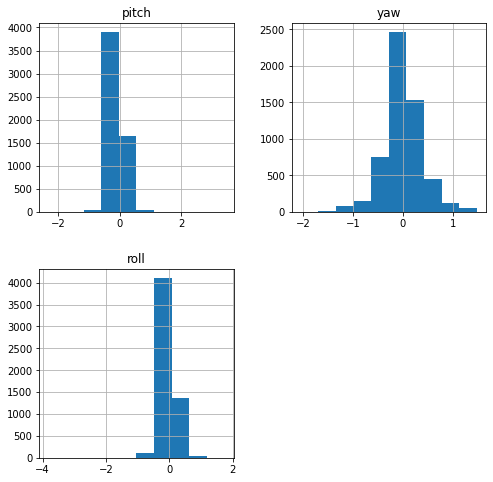

In [4]:
df[['pitch','yaw','roll']].hist(figsize=(8,8))
fig = go.Figure()
fig.add_trace(go.Box(y= df['pitch'],name="pitch"),)
fig.add_trace(go.Box(y=df['yaw'],name= "yaw"))
fig.add_trace(go.Box(y=df['roll'],name = "roll"))

fig.show()

Data after removing Outliers

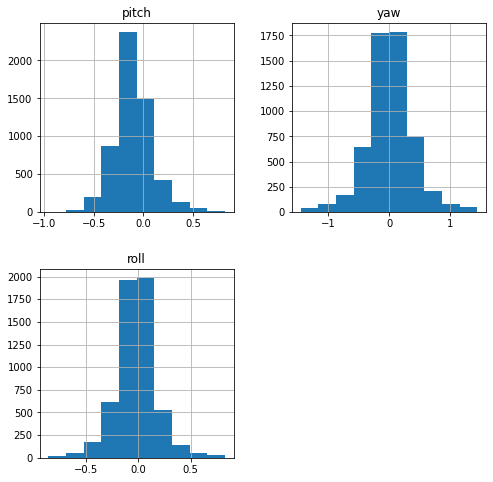

In [5]:
#delete outliers in pitch and yaw
for col in ['pitch','yaw','roll']:
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    max = df[col].quantile(0.75) +4*IQR
    min = df[col].quantile(0.25) -4*IQR 
    outlierdf = df[(df[col] > max) | (df[col] < min)]
    df.drop(df[(df[col] > max) | (df[col] < min)].index, inplace=True)


df[['pitch','yaw','roll']].hist(figsize=(8,8))

fig = go.Figure()
fig.add_trace(go.Box(y= df['pitch'],name="pitch"),)
fig.add_trace(go.Box(y=df['yaw'],name= "yaw"))
fig.add_trace(go.Box(y=df['roll'],name = "roll"))

fig.show()

save data without outliers

In [6]:
outlierdf.to_csv("outlierdf.csv",index=False)
outlierdf

,0,1,2,3,4,5,6,7,8,9,...,930,931,932,933,934,935,pitch,yaw,roll,image
4,0.418149,0.372060,0.413411,0.380015,0.366450,0.373381,0.400533,0.397151,0.402687,0.396203,...,0.629102,0.512914,0.520378,0.526523,0.498481,0.488337,-0.882169,1.198004,-1.033374,image00010
255,0.556911,0.599254,0.563711,0.586580,0.605667,0.603458,0.592128,0.470089,0.600204,0.609083,...,0.625164,0.497844,0.502437,0.506529,0.499112,0.489989,-0.821108,-1.051044,0.981375,image00460
258,0.577080,0.565692,0.575333,0.554905,0.564211,0.565392,0.573299,0.459896,0.575382,0.575003,...,0.637565,0.522025,0.526566,0.530201,0.519952,0.507918,-0.837746,-1.151385,0.945900,image00472
333,0.568629,0.523646,0.538543,0.458636,0.507408,0.485826,0.430506,0.319275,0.384898,0.362151,...,0.643186,0.493438,0.507352,0.518953,0.405070,0.387849,-0.238633,-0.004876,-0.907422,image00602
400,0.549760,0.477101,0.508698,0.420935,0.458550,0.440724,0.400640,0.328584,0.357247,0.331992,...,0.624584,0.476894,0.491982,0.503480,0.384323,0.365592,-0.315775,0.262099,-0.879449,image00733
446,0.532512,0.559703,0.536419,0.544355,0.563412,0.560726,0.548859,0.434933,0.549881,0.555034,...,0.611866,0.479530,0.486739,0.493173,0.476778,0.465693,-1.049992,-1.194372,1.290950,image00815
453,0.593610,0.623381,0.595839,0.604656,0.626680,0.621998,0.603850,0.487107,0.601590,0.605257,...,0.618163,0.501642,0.506943,0.511711,0.491661,0.480248,-0.948136,-1.241852,1.234426,image00831
599,0.481171,0.442169,0.472602,0.432759,0.434698,0.434212,0.439890,0.422693,0.431166,0.421207,...,0.626813,0.514151,0.521908,0.528433,0.488794,0.477434,-0.711090,1.135151,-0.904919,image01095
821,0.533555,0.584373,0.543214,0.575944,0.593303,0.591727,0.578160,0.469106,0.585813,0.596482,...,0.637059,0.523152,0.528758,0.534672,0.523654,0.515777,-0.928203,-0.992324,0.883680,image01711
1012,0.503777,0.475564,0.496138,0.458830,0.469828,0.468356,0.470486,0.385089,0.462562,0.455892,...,0.596671,0.473953,0.480288,0.485176,0.455539,0.443774,0.070735,-0.044993,-1.395981,image02214


In [7]:
# investigat outlier images
outlierdf[outlierdf['pitch'] == outlierdf['pitch'].max()]

,0,1,2,3,4,5,6,7,8,9,...,930,931,932,933,934,935,pitch,yaw,roll,image
1239,0.438567,0.456289,0.460575,0.481473,0.464642,0.479747,0.522139,0.438724,0.546272,0.556356,...,0.601451,0.516398,0.517527,0.517301,0.533204,0.523671,0.412283,0.162895,0.851172,image02845


display points before normalization

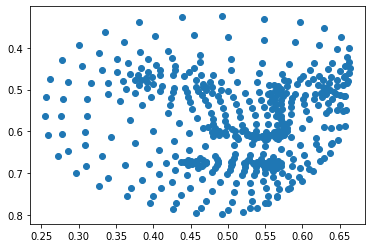

In [8]:
#display points for one row before normalization
row =150
plt.scatter(x=df.iloc[row,0:467],y=df.iloc[row,468:935])
plt.gca().invert_yaxis()


## select features and split data

normalize data

In [9]:
df.iloc[:,0:468]= (df.iloc[:,0:468].values /df.iloc[:,1].values.reshape(-1,1))-1
df.iloc[:,468:936]= (df.iloc[:,468:936].values /df.iloc[:,469].values.reshape(-1,1))-1

display points after normalization

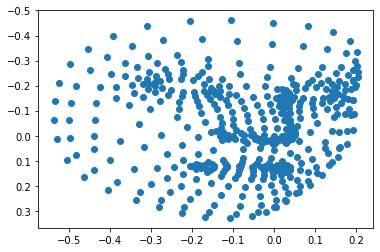

In [10]:
#display points for one row before normalization
row =150
plt.scatter(x=df.iloc[row,0:467],y=df.iloc[row,468:935])
plt.gca().invert_yaxis()


# Dividing data using train_test_split
Training:80%  Testing: 20%

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(df.iloc[:,0:-4],
df.iloc[:,-4:-1],test_size=0.2,random_state=0)
print(X_train.shape)
print(X_test.shape)
X_train

(4454, 936)
(1114, 936)


,0,1,2,3,4,5,6,7,8,9,...,926,927,928,929,930,931,932,933,934,935
260,0.046416,0.0,0.079218,0.074078,0.003958,0.042897,0.165904,0.160333,0.207834,0.209133,...,0.022709,0.015981,0.048446,0.022242,0.032593,-0.133167,-0.126017,-0.121829,-0.136039,-0.148410
1134,0.015430,0.0,0.005356,-0.039910,-0.003671,-0.006752,-0.012382,-0.270435,-0.018978,-0.022817,...,0.012936,0.001081,0.021323,0.015345,0.023882,-0.168110,-0.161975,-0.159042,-0.184491,-0.198699
2523,-0.031422,0.0,-0.026513,-0.034930,0.003063,-0.003431,-0.027964,-0.255472,-0.032046,-0.028131,...,0.014978,0.007275,0.031384,0.015889,0.023889,-0.115438,-0.112164,-0.110712,-0.109967,-0.116583
2245,0.063846,0.0,0.041397,-0.036805,-0.010909,-0.012669,-0.003812,-0.224823,-0.014394,-0.026875,...,-0.003708,-0.012686,-0.023171,0.001118,0.000583,-0.215586,-0.203411,-0.191575,-0.253969,-0.266330
1030,0.048663,0.0,0.026732,-0.056198,-0.011289,-0.019814,-0.032227,-0.309757,-0.054451,-0.070106,...,0.002130,-0.013602,-0.023251,0.007832,0.012669,-0.234697,-0.224898,-0.217295,-0.287376,-0.307321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3197,-0.026019,0.0,-0.019830,-0.029712,0.004231,0.002727,-0.008651,-0.261788,-0.008940,-0.005173,...,-0.000684,-0.009640,-0.009624,0.003791,0.004732,-0.189444,-0.179900,-0.170886,-0.208573,-0.217780
1529,-0.027218,0.0,-0.011765,-0.008727,0.007149,0.013698,0.027641,-0.200840,0.041087,0.050061,...,0.007279,0.000826,0.004979,0.010484,0.012223,-0.178064,-0.172235,-0.166466,-0.173927,-0.177792
1681,0.054997,0.0,0.053279,0.004366,-0.005749,0.006202,0.058751,-0.068045,0.072684,0.069746,...,0.021754,0.012813,0.041952,0.022205,0.032661,-0.145049,-0.139751,-0.136684,-0.141048,-0.165202
859,0.033836,0.0,0.023558,-0.030325,-0.006480,-0.006561,0.001498,-0.214221,-0.004109,-0.012835,...,0.001376,-0.008162,-0.009942,0.005487,0.007875,-0.193323,-0.183009,-0.174642,-0.227923,-0.235428


In [12]:
Y_train

,pitch,yaw,roll
260,0.697415,1.145306,0.348884
1134,0.010771,0.079884,-0.061865
2523,0.096793,-0.447590,0.042989
2245,-0.296962,0.324625,-0.215569
1030,-0.297765,0.086323,-0.223150
...,...,...,...
3197,-0.347687,-0.220189,0.093661
1529,-0.099958,-0.137162,0.146343
1681,0.640810,0.692177,-0.070467
859,-0.164684,0.201552,-0.127230


### SVR model

**After all the Attempts on different models, we will know that SVR is the best performer**

In [18]:
svmModel = make_pipeline(Normalizer(),
                MultiOutputRegressor(SVR(C = 0.2,kernel="poly"),n_jobs=-1)
                )
svmModel.fit(X_train, Y_train)
predictions =  svmModel.predict(X_train.values)
print("mean_squared_error for trainning",mean_squared_error(Y_train, predictions))
print("r2_score for trainning",r2_score(Y_train, predictions))
print("#######################################")
test_predictions =  svmModel.predict(X_test.values)
print("mean_squared_error for test data",mean_squared_error(Y_test, test_predictions))
print("r2_score for test data",r2_score(Y_test, test_predictions))
print("#######################################")
print("r2_score for test pitch",r2_score(Y_test['pitch'], test_predictions[:,0]))
print("r2_score for test yaw",r2_score(Y_test['yaw'], test_predictions[:,1]))
print("r2_score for test roll",r2_score(Y_test['roll'], test_predictions[:,2]))

C:\Users\ahmed\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but Normalizer was fitted with feature names



mean_squared_error for trainning 0.011931288209661153
r2_score for trainning 0.8039079268502555
#######################################


C:\Users\ahmed\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but Normalizer was fitted with feature names



mean_squared_error for test data 0.010923234801548143
r2_score for test data 0.8125019612498007
#######################################
r2_score for test pitch 0.7413400109188473
r2_score for test yaw 0.8883512325116208
r2_score for test roll 0.8078146403189339


In [19]:
dump(svmModel, 'svrBoostingRegressor_mediapipe.joblib')

['svrBoostingRegressor_mediapipe.joblib']

### try RandomForestRegressor model

In [20]:
random_clf = make_pipeline(Normalizer(),
                    MultiOutputRegressor(RandomForestRegressor(random_state=0,n_estimators=500,max_depth=5,n_jobs=-1),n_jobs=-1) #best time to score when 6000 6
                    )

random_clf.fit(X_train.values, Y_train.values)
predictions =  random_clf.predict(X_train.values)
print("mean_squared_error for trainning",mean_squared_error(Y_train.values, predictions))
print("r2_score for trainning",r2_score(Y_train.values, predictions))
print("#######################################")
test_predictions =  random_clf.predict(X_test.values)
print("mean_squared_error for test data",mean_squared_error(Y_test, test_predictions))
print("r2_score for test data",r2_score(Y_test, test_predictions))
print("#######################################")
print("r2_score for test pitch",r2_score(Y_test['pitch'], test_predictions[:,0]))
print("r2_score for test yaw",r2_score(Y_test['yaw'], test_predictions[:,1]))
print("r2_score for test roll",r2_score(Y_test['roll'], test_predictions[:,2]))

mean_squared_error for trainning 0.008511732805934959
r2_score for trainning 0.8570994005482611
#######################################
mean_squared_error for test data 0.010935340076990324
r2_score for test data 0.8113026151208773
#######################################
r2_score for test pitch 0.7192751355209219
r2_score for test yaw 0.889460601236625
r2_score for test roll 0.825172108605085


In [21]:
dump(random_clf, 'RandomForestRegressor_mediapipe.joblib')

['RandomForestRegressor_mediapipe.joblib']

### try XGBRegressor

In [22]:
xg_clf = make_pipeline(StandardScaler(),
                    MultiOutputRegressor(XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, nthread=-1,seed=0),n_jobs=-1)
                    )

xg_clf.fit(X_train.values, Y_train.values)

predictions =  xg_clf.predict(X_train.values)
print("mean_squared_error for trainning",mean_squared_error(Y_train.values, predictions))
print("r2_score for trainning",r2_score(Y_train.values, predictions))
print("#######################################")
test_predictions =  xg_clf.predict(X_test.values)
print("mean_squared_error for test data",mean_squared_error(Y_test, test_predictions))
print("r2_score for test data",r2_score(Y_test, test_predictions))
print("#######################################")
print("r2_score for test pitch",r2_score(Y_test['pitch'], test_predictions[:,0]))
print("r2_score for test yaw",r2_score(Y_test['yaw'], test_predictions[:,1]))
print("r2_score for test roll",r2_score(Y_test['roll'], test_predictions[:,2]))

mean_squared_error for trainning 0.0024520875191480812
r2_score for trainning 0.955134291769299
#######################################
mean_squared_error for test data 0.01046030883095056
r2_score for test data 0.8184302411579735
#######################################
r2_score for test pitch 0.7370407254669844
r2_score for test yaw 0.8954767633287304
r2_score for test roll 0.8227732346782055


In [23]:
dump(xg_clf, 'XGBRegressor_mediapipe.joblib')

['XGBRegressor_mediapipe.joblib']

# Draw lines of predictions

In [24]:
def draw_axis(img,pitch, yaw,  roll, tdx=None, tdy=None, size = 100):
    
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (np.cos(yaw) * np.cos(roll)) + tdx
    y1 = size * (np.cos(pitch) * np.sin(roll) + np.cos(roll) * np.sin(pitch) * np.sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-np.cos(yaw) * np.sin(roll)) + tdx
    y2 = size * (np.cos(pitch) * np.cos(roll) - np.sin(pitch) * np.sin(yaw) * np.sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (np.sin(yaw)) + tdx
    y3 = size * (-np.cos(yaw) * np.sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

## apply model on the video

In [27]:
video_path = r"C:\Users\ahmed\Downloads\WhatsApp Video 2022-06-18 at 4.25.40 PM.mp4"

faces = mediapipe.solutions.face_mesh.FaceMesh()
cap = cv2.VideoCapture(video_path)
pit = yaw =rol = tdx = tdy =0
#save video
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
   
size = (frame_width, frame_height)
result = cv2.VideoWriter('video.mp4', 
                        -1,
                         20, size)
#######################################
while(cap.isOpened()):
    # load the input image and convert it to grayscale
    _, frame = cap.read()

    results = faces.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
        # looping over the faces in the frame
        for face in results.multi_face_landmarks:
            xarr=[]
            yarr=[]

            for landmark in face.landmark:
                print
                x = landmark.x
                y = landmark.y

                xarr.append(x)
                yarr.append(y)
                shape = frame.shape 
                relative_x = int(x * shape[1])
                relative_y = int(y * shape[0])
                # cv2.circle(frame, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
            arr = np.array([xarr,yarr]).reshape(1,-1)
            arr[:,0:468]= (arr[:,0:468] /arr[:,1].reshape(-1,1))-1
            arr[:,468:936]= (arr[:,468:936] /arr[:,469].reshape(-1,1))-1
            predict = svmModel.predict(arr)
            pit=predict[0,0]
            yaw=-predict[0,1]
            rol=predict[0,2]
            yawlook = ""
            pitlook = ""
            rolllook = ""
            if np.tan(yaw)>0.17632698070846498 and np.tan(yaw)<0.9999999999999999:
                yawlook ="look left"
            elif np.tan(yaw)<-0.17632698070846498 and np.tan(yaw)>-0.9999999999999999:
                yawlook =  "look right"

            #pitch look up and down
            if np.tan(pit)>0.17632698070846498 and np.tan(pit)<0.9999999999999999:
                pitlook = "look up"
            elif np.tan(pit)<-0.17632698070846498 and np.tan(pit)>-0.9999999999999999:
                pitlook = "look down"
            #roll shake left and right
            if np.tan(rol)>0.17632698070846498 and np.tan(rol)<0.9999999999999999:
                rolllook = "shake right"
            elif np.tan(rol)<-0.17632698070846498 and np.tan(rol)>-0.9999999999999999:
                rolllook = "shake left"
           
            cv2.putText(frame,'yaw : '+yawlook, (0, 20), cv2.FONT_HERSHEY_SIMPLEX,0.7, (246,255,12), 2)
            cv2.putText(frame,'pitch : ' + pitlook, (0, 50), cv2.FONT_HERSHEY_SIMPLEX,0.7, (246,255,12), 2)
            cv2.putText(frame,'roll : '+ rolllook, (0, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (246,255,12),2)
            tdx=int(xarr[1] * shape[1])
            tdy=int(yarr[1] * shape[0])
            # bbox_height, bbox_width = frame.shape[:2]
    ff = draw_axis(frame,pit,yaw,rol,tdx,tdy)
    result.write(ff)
    cv2.imshow("Output",ff)

    k = cv2.waitKey(5) & 0xFF
    if k == 27:
        break
cap.release()
result.release()

cv2.destroyAllWindows()